###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2021 Semester 1

## Assignment 1: Pose classification with naive Bayes


**Student ID(s):**     `867492 Haonan Zhong`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [1]:
import numpy as np
import pandas as pd
import math

In [2]:
# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing

def preprocess(train_file, test_file):
    # read in both file as pandas DataFrame
    train = pd.read_csv(train_file, header = None)
    test = pd.read_csv(test_file, header = None)

    # exclude instances that contains only 9999 for x and y values
    train = train[train.iloc[:, 1:].mean(axis = 1) != 9999]

    # replace missing values with NaN
    train = train.replace(9999, np.nan)
    test = test.replace(9999, np.nan)
    
    # fill in missing keypoints by class with mean value of rach column
    for i in range(1, train.shape[1]):
        train[i] = train[i].fillna(train.groupby(train[0])[i].transform('mean'))
    
    return train, test

train_file = "train.csv"
test_file = "test.csv"
train_clean, test_clean = preprocess(train_file, test_file)

In [3]:
# This function calculates the prior probabilities, mean and standard deviation of each column from the given
# training data and use them to build a naive Bayes model

def train(train_df):

    # compute the prior probabilities for each class label
    priors = train_df[0].value_counts() / float(len(train_df))
    class_lbl = list(priors.keys())

    # Use dicitonary to store mean and standard deviation of each attribute for each label
    model = dict()
    # loop through every class in train dataset
    for lbl in class_lbl:
        class_mean = list(train_df[train_df[0] == lbl].describe().loc["mean"])
        class_std = list(train_df[train_df[0] == lbl].describe().loc["std"])
        model[lbl] = {"prior": priors[lbl], "mean": class_mean, "std": class_std}
    
    return model

model = train(train_clean)

In [4]:
# This function calculates the normal density of a given x, mean and standard deviation

def normal_pdf(x, mu, std):
    exponent = math.exp(-((x-mu)**2 / (2 * std**2 )))
    return (1 / (math.sqrt(2 * math.pi) * std)) * exponent

In [5]:
# This function calculates the log gaussian density of given x, mean and standard deviation

def log_gaussian(x, mu, std):
    # calculate the normal density with the given x, mu, sigma
    density = normal_pdf(x, mu, std)

    # return an arbitrary likelihood if instance attribute is missing
    # or likelihood equals to 0
    if (np.isnan(x)) or (density == 0):
        return math.log(1e-8)
    
    # Otherwise calculate and return the density with the given numbers
    else:
        return math.log(density)

In [6]:
# This function calculate and predict the class label for each instances in a given dataset

def predict(test, model):
    # store the predicted class label for evaluation
    predicted_lbl = []
    class_lbl = list(model.keys())

    # Loop through every instances in the test dataset
    for index, row in test.iterrows():
        scores = []
        # Calculate posterior of each instance given different class
        for lbl in class_lbl:
            # retrieve the prior of the given class
            score = np.log(model[lbl]["prior"])

            # Loop every attribute of the instance and compute the probability
            for i, x in enumerate(row[1:]):
                score += log_gaussian(x, model[lbl]["mean"][i], model[lbl]["std"][i])
            # records the score of each label for the instance
            scores.append(score)
        
        # classify each test instance according to the largest probability computed
        predicted_lbl.append(class_lbl[np.argmax(scores)])
    return predicted_lbl

actual_lbl = test_clean[0]
predicted_lbl = predict(test_clean, model)

In [7]:
# This function evaluate the prediction performance by comparing the predicted label and the actual labels

def evaluate(actual_lbl, predicted_lbl):

    # count how many predictions matches the actual label
    count = np.sum(predicted_lbl == actual_lbl)

    # return the accuracy
    return count / float(len(actual_lbl))

accuracy = evaluate(actual_lbl, predicted_lbl)
print("Test Data Accuracy:", accuracy)

Test Data Accuracy: 0.7413793103448276


## Questions 


If you are in a group of 1, you will respond to **two** questions of your choosing.

If you are in a group of 2, you will respond to **four** questions of your choosing.

A response to a question should take about 100–250 words, and make reference to the data wherever possible.

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer should be submitted separately as a PDF.

### Q1
Since this is a multiclass classification problem, there are multiple ways to compute precision, recall, and F-score for this classifier. Implement at least two of the methods from the "Model Evaluation" lecture and discuss any differences between them. (The implementation should be your own and should not just call a pre-existing function.)

In [8]:
# This function computes the confusion matrix between the ground truth label and predicted label

def confusion_matrix(actual_lbl, predicted_lbl, lbl_names):
    num_lbls = len(lbl_names)
    c_matrix = np.zeros((num_lbls, num_lbls))
    for i, x in enumerate(actual_lbl):
        lbl = predicted_lbl[i]
        c_matrix[lbl_names.index(x), lbl_names.index(lbl)] += 1
    return c_matrix

In [9]:
# This function calculate and print precision, recall and f-score of each score, then calculates the
# macro-averaged and micro-averaged precision, recall and f-score

def class_report(actual_lbl, predicted_lbl, class_name):
    # Compute the confusion mateix between actual label and predicted label
    c_matrix = confusion_matrix(actual_lbl, predicted_lbl, lbl_names)
    display(pd.DataFrame(c_matrix))

    # compute precision, recall and f score for each class
    tp = np.diag(c_matrix)
    precision = tp / c_matrix.sum(axis=0)
    recall = tp / c_matrix.sum(axis=1)
    f_score = (2 * precision * recall) / (precision + recall)
    support = c_matrix.sum(axis=1)
    report_df = {
        'Class': class_name,
        'Precision': precision,
        'Recall': recall,
        'F-score': f_score,
        'Support': support,
        }
    report_df = pd.DataFrame(data=report_df)

    macro_precision = precision.mean()
    macro_recall = recall.mean()
    macro_f_score = f_score.mean()
    micro_precision = tp.sum() / (c_matrix.sum(axis = 0).sum())
    micro_recall = tp.sum() / (c_matrix.sum(axis = 1).sum())
    micro_f_score = (2 * micro_precision * micro_recall) / (micro_precision + micro_recall)

    # print the results
    display(report_df.round(2))
    print("\nMacro precision: {a:3.2f}  Macro recall: {b:3.2f}  Macro F1: {c:3.2f}".\
          format(a = macro_precision, b= macro_recall, c = macro_f_score))
    print("Micro precision: {a:3.2f}  Micro recall: {b:3.2f}  Micro F1: {c:3.2f}".\
          format(a = micro_precision, b= micro_recall, c = micro_f_score))

# retrieve the set of class label
lbl_names = list(dict.fromkeys(actual_lbl))
class_report(actual_lbl, predicted_lbl, lbl_names)

,0,1,2,3,4,5,6,7,8,9
0,8.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,11.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,1.0,12.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,26.0,0.0,0.0,4.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,7.0,1.0,0.0,1.0,0.0,0.0
5,0.0,2.0,0.0,0.0,2.0,4.0,0.0,1.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0


,Class,Precision,Recall,F-score,Support
0,bridge,0.80,0.57,0.67,14.0
1,childs,0.69,0.85,0.76,13.0
2,downwarddog,0.86,0.67,0.75,18.0
3,mountain,0.87,0.87,0.87,30.0
4,plank,0.58,0.78,0.67,9.0
5,seatedforwardbend,0.57,0.44,0.50,9.0
6,tree,0.38,0.50,0.43,6.0
7,trianglepose,0.67,1.00,0.80,4.0
8,warrior1,0.67,0.80,0.73,5.0
9,warrior2,1.00,0.88,0.93,8.0



Macro precision: 0.71  Macro recall: 0.73  Macro F1: 0.71
Micro precision: 0.74  Micro recall: 0.74  Micro F1: 0.74


In [10]:
# Use sklearn functions to check answers

from sklearn.metrics import classification_report
print(classification_report(actual_lbl, predicted_lbl))

                   precision    recall  f1-score   support

           bridge       0.80      0.57      0.67        14
           childs       0.69      0.85      0.76        13
      downwarddog       0.86      0.67      0.75        18
         mountain       0.87      0.87      0.87        30
            plank       0.58      0.78      0.67         9
seatedforwardbend       0.57      0.44      0.50         9
             tree       0.38      0.50      0.43         6
     trianglepose       0.67      1.00      0.80         4
         warrior1       0.67      0.80      0.73         5
         warrior2       1.00      0.88      0.93         8

        micro avg       0.74      0.74      0.74       116
        macro avg       0.71      0.73      0.71       116
     weighted avg       0.76      0.74      0.74       116



### Q2
The Gaussian naıve Bayes classifier assumes that numeric attributes come from a Gaussian distribution. Is this assumption always true for the numeric attributes in this dataset? Identify some cases where the Gaussian assumption is violated and describe any evidence (or lack thereof) that this has some effect on the classifier’s predictions.

### Q3
Implement a kernel density estimate (KDE) naive Bayes classifier and compare its performance to the Gaussian naive Bayes classifier. Recall that KDE has kernel bandwidth as a free parameter -- you can choose an arbitrary value for this, but a value in the range 5-25 is recommended. Discuss any differences you observe between the Gaussian and KDE naive Bayes classifiers. (As with the Gaussian naive Bayes, this KDE naive Bayes implementation should be your own and should not just call a pre-existing function.)

In [11]:
# This function preprocess the train dataset without filling the missing values by class mean

def kde_preprocess(train_file, test_file):
    train = pd.read_csv(train_file, header = None)
    test = pd.read_csv(test_file, header = None)
    # exclude instances that contains only 9999 for x and y values
    train = train[train.iloc[:, 1:].mean(axis = 1) != 9999]

    # replace missing values with NaN to improve accuracy during training
    train = train.replace(9999, np.nan)
    test = test.replace(9999, np.nan)

    return train, test

kde_train_clean, kde_test_clean = kde_preprocess(train_file, test_file)

In [12]:
# This function computes the prior probabilities of all classes and stores all columns as numpy array

def kde_train(train):
    # compute the prior of each class
    priors = train[0].value_counts() / float(len(train))
    class_lbl = list(priors.keys())

    # store all train data as dictionary
    kde_model = dict()
    for lbl in class_lbl:
        # store each column of the class as an array
        subset = np.array(train[train[0] == lbl].iloc[:, 1:].transpose())
        kde_model[lbl] = {"prior": priors[lbl], "x": subset}
    return kde_model

kde_model = kde_train(kde_train_clean)

In [13]:
# This function calculates the kde density based on gaussian distribution with mean equals to 0 and sigma
# equals to an arbritary number, x_test here is the test attribute and x_train is the column of train dataset

def kde_gaussian(x, train_column, bandwidth):
    missing = 0
    density = []

    # return a very small likelihood if x is missing
    if (np.isnan(x)):
        return math.log(1e-8)

    # calculate every combination of x - xi
    for xi in train_column:
        # ignore and count the numbers of missing values in train data
        if (np.isnan(xi)):
            missing += 1
        else:
            density.append(normal_pdf(x - xi, 0, bandwidth))
    
    likelihood = sum(density) / (len(train_column) - missing)
    # return an arbitrary number if likelihood equals to zero
    if (likelihood == 0):
        return math.log(1e-8)
    else:
        return math.log(likelihood)

In [14]:
# This function computes the density of every row of the given test dataframe and classifies the class label
# based on probabilites using kernel density estimation

def kde_predict(test, model):
    # array to store all predicted class label
    predicted_lbl = []
    class_lbl = list(model.keys())

    # loop through every instance in test dataset
    for index, row in test.iterrows():
        scores = []
        for lbl in class_lbl:
            # retrieve the prior of the current class
            score = math.log(model[lbl]["prior"])

            # calculate the likelihood of every attribute of the current instance
            for i, x in enumerate(row[1:]):
                score += kde_gaussian(x, model[lbl]["x"][i], 10)
            scores.append(score)
        
        # classify each test instance according to the largest probability computed
        predicted_lbl.append(class_lbl[np.argmax(scores)])
    return predicted_lbl

kde_actual_lbl = kde_test_clean[0]
kde_predict_lbl = kde_predict(kde_test_clean, kde_model)
kde_accuracy = evaluate(kde_actual_lbl, kde_predict_lbl)
print("Accuracy:", kde_accuracy)

Accuracy: 0.7758620689655172


In [15]:
# classification report for kde model

class_report(kde_actual_lbl, kde_predict_lbl, lbl_names)

,0,1,2,3,4,5,6,7,8,9
0,9.0,1.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
1,0.0,10.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,14.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,26.0,0.0,0.0,4.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,1.0,0.0
5,0.0,1.0,1.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7.0


,Class,Precision,Recall,F-score,Support
0,bridge,0.82,0.64,0.72,14.0
1,childs,0.83,0.77,0.80,13.0
2,downwarddog,0.82,0.78,0.80,18.0
3,mountain,0.87,0.87,0.87,30.0
4,plank,0.58,0.78,0.67,9.0
5,seatedforwardbend,0.86,0.67,0.75,9.0
6,tree,0.40,0.67,0.50,6.0
7,trianglepose,1.00,1.00,1.00,4.0
8,warrior1,0.50,0.60,0.55,5.0
9,warrior2,1.00,0.88,0.93,8.0



Macro precision: 0.77  Macro recall: 0.76  Macro F1: 0.76
Micro precision: 0.78  Micro recall: 0.78  Micro F1: 0.78


In [26]:
# This cell shows how long it takes to run kde naive bayes and gaussian naive bayes, respectively
import time

start_time  = time.time()
kde_predict(kde_test_clean, kde_model)
end_time = time.time()
print("Time used for KDE prediction:", end_time - start_time)
start_time  = time.time()
predict(test_clean, model)
end_time = time.time()
print("Time used for gaussian prediction:", end_time - start_time)

Time used for KDE prediction: 5.197180986404419
Time used for gaussian prediction: 0.20087409019470215


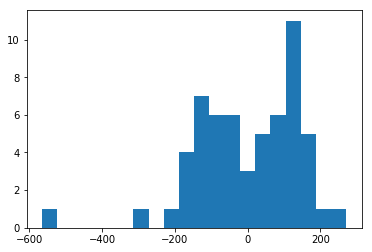

In [24]:
# The following section plots the histogram, kernel denisty estimate and normal distribution of a chosen
# attribute

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline

attribute = np.array(kde_train_clean[kde_train_clean[0] == "bridge"][1])
attribute = list(attribute[~np.isnan(attribute)])
plt.hist(attribute, bins=20)
plt.show()

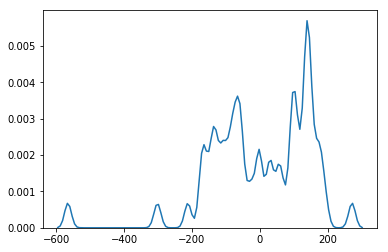

In [18]:
# Kernel density estimate with bandwidth equals to 10

sns.kdeplot(attribute, bw = 10)

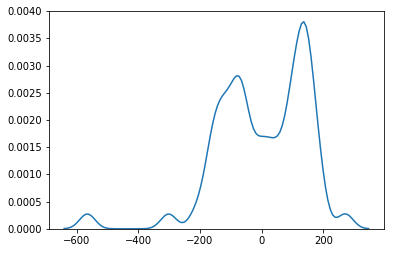

In [19]:
sns.kdeplot(attribute, bw = 25)

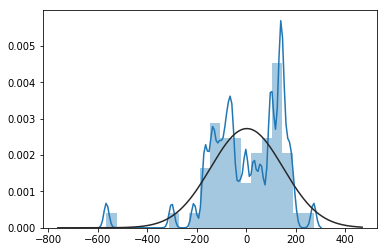

In [20]:
sns.distplot(attribute, bins= 20 ,fit=norm, kde_kws={'bw':10})

### Q4
Instead of using an arbitrary kernel bandwidth for the KDE naive Bayes classifier, use random hold-out or cross-validation to choose the kernel bandwidth. Discuss how this changes the model performance compared to using an arbitrary kernel bandwidth.

### Q5
Naive Bayes ignores missing values, but in pose recognition tasks the missing values can be informative. Missing values indicate that some part of the body was obscured and sometimes this is relevant to the pose (e.g., holding one hand behind the back). Are missing values useful for this task? Implement a method that incorporates information about missing values and demonstrate whether it changes the classification results.

### Q6
Engineer your own pose features from the provided keypoints. Instead of using the (x,y) positions of keypoints, you might consider the angles of the limbs or body, or the distances between pairs of keypoints. How does a naive Bayes classifier based on your engineered features compare to the classifier using (x,y) values? Please note that we are interested in explainable features for pose recognition, so simply putting the (x,y) values in a neural network or similar to get an arbitrary embedding will not receive full credit for this question. You should be able to explain the rationale behind your proposed features. Also, don't forget the conditional independence assumption of naive Bayes when proposing new features -- a large set of highly-correlated features may not work well.